# 5 - Single Kramers chain analysis
Here we will be only looking at a single chain and what tools are available to plot the dynamics.

In [1]:
import numpy as np
from dilutebrowniandynamics.simulate import simulate
from dilutebrowniandynamics.molecules.Kramers_chain import KramersChain

## Parameters definition

In [2]:
n_links = 1000       # Number of segments in the Kramers chain

output_file = 'outputs/sandpit'

## Initialise molecules
Here we just draw random vectors from a normal distribution and rescale to unit vectors. To do this with call `from_normal_distribution` constructor. 

In [3]:
# Starting vectors
molecule = KramersChain.from_normal_distribution(n_links, np.random.SeedSequence(2022))

We can plot this molecule using matplotlib 3d capabilities: firt we need to convert links to coordinates.

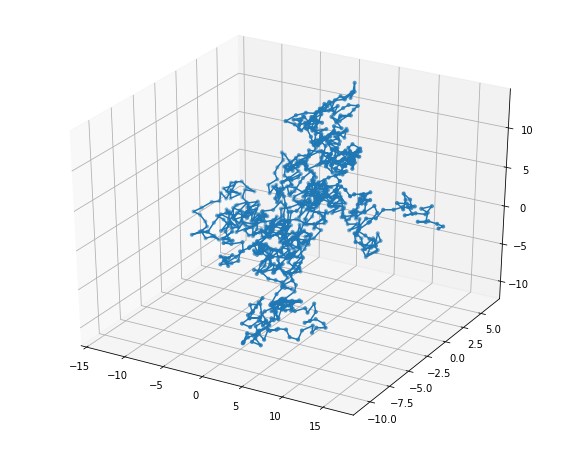

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [10, 8]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xyz = molecule.coordinates
x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
ax.plot(x, y, z)
ax.scatter(x, y, z, s=10)

Or we can export the molecule to vtk format which can be read by Paraview.

In [5]:
molecule.save_vtk('outputs/vtk/example.vtk')

## Initial relaxation
Thermalisation step.

In [6]:
gradU = np.zeros((3, 3))
dt = .01           # Time step value (dimensionless)
n_steps = 2000        # Number of time steps to record
write_interval = 1

observables, molecule = simulate(molecule, gradU, dt, n_steps,
                                 write_interval=write_interval, full_trajectory=False, progress=True)

100%|██████████████████████████████████████| 2000/2000 [00:04<00:00, 487.90it/s]


In [7]:
molecule.save_vtk('outputs/vtk/example_equilibrium.vtk')

## Simulation
Now let's simulate a sudden uniaxial elongation followed by relaxation. We first define a callable `gradU` function for this scenario.

In [8]:
from scipy.interpolate import interp1d
t_base = [0, # Elongation starts at t = 0
          10] # Relaxation will start from t = 5
gradU_base = [np.diag([1, -.5, -.5]),
              np.zeros((3, 3))]
gradU = interp1d(t_base, gradU_base, axis=0, kind='previous', bounds_error=False, 
                 fill_value=(gradU_base[0], gradU_base[-1]), assume_sorted=True)

In [9]:
dt = .01           
n_steps = 1_000
observables, trajectory = simulate(molecule, gradU, dt, n_steps,
                                 write_interval=write_interval, full_trajectory=True, progress=True)

100%|███████████████████████████████████████| 1000/1000 [23:59<00:00,  1.44s/it]


## Analysing tensions in the molecule

We can analysed the trajectory (collection of time steps) interactively in this Notebook:

In [10]:
from ipywidgets import interact
x_min = np.min(np.array([molecule.coordinates[:,0] for molecule in trajectory]))
x_max = np.max(np.array([molecule.coordinates[:,0] for molecule in trajectory]))
y_min = np.min(np.array([molecule.coordinates[:,1] for molecule in trajectory]))
y_max = np.max(np.array([molecule.coordinates[:,1] for molecule in trajectory]))
z_min = np.min(np.array([molecule.coordinates[:,2] for molecule in trajectory]))
z_max = np.max(np.array([molecule.coordinates[:,2] for molecule in trajectory]))
min_min = min(x_min, y_min, z_min)
max_max = max(x_max, y_max, z_max)

@interact
def display_molecule(step=(0,len(trajectory)-1,1)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    molecule = trajectory[step]
    xyz = molecule.coordinates
    x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
    c = np.zeros_like(x)
    c[:-1] = 0.5*molecule.tensions
    c[1:] = 0.5*molecule.tensions
    ax.plot(x, y, z)
    im = ax.scatter(x, y, z, s=10, c=c)
    ax.scatter([min_min, max_max], [min_min, max_max], [min_min, max_max], s=0)
    fig.colorbar(im, ax=ax, label='Dimensionless tension')
    plt.show()


interactive(children=(IntSlider(value=499, description='step', max=999), Output()), _dom_classes=('widget-inte…

Or we can save a sequence of vtk files to make an animation later in Paraview:

In [11]:
for i in range(0,len(trajectory),1):
    trajectory[i].save_vtk(f'outputs/vtk/time_{i}.vtk')

To see how the molecule unravels, we can plot tension as function of time in a 2d plot:

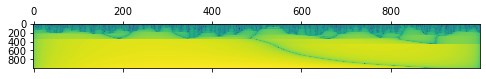

In [14]:
mat = np.empty((n_steps,n_links))
for i in range(n_steps):
    mat[i] = trajectory[i].tensions
    
plt.matshow(np.log(abs(mat)), aspect=0.1)

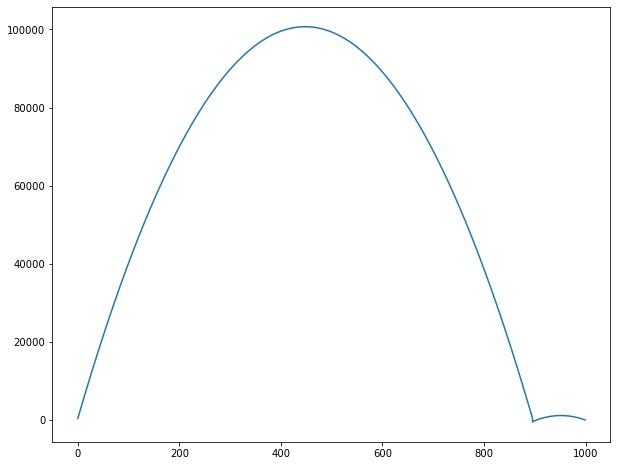

In [15]:
plt.plot(trajectory[999].tensions)

## Performance profiling

## Adaptive solver survey

In [ ]:
molecule = KramersChain.from_normal_distribution(n_links)

In [ ]:
molecule.Q[:, 0] = 1
molecule.Q[:, 1:] = 0
molecule.Q += 0.001*np.random.standard_normal((n_links, 3))
molecule.Q[10, 0] = -1

norms = np.sqrt(np.sum(molecule.Q**2, axis=1))
molecule.Q = molecule.Q/norms[:, None]

molecule.Q

In [ ]:
molecule.dW = 0.
molecule.solve(np.diag([1., -.5, -.5]), 0.1)
molecule.evolve()
molecule.Q

In [ ]:
molecule.tensions

In [ ]:
10*True